In [9]:
import ROOT
import json

In [10]:

root_file = ROOT.TFile("/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root")
th2d_histogram = root_file.Get("Pixel/"+"2017"+"/"+"2017B"+"/h"+"45"+"_220_"+"2017B"+"_all_2D")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


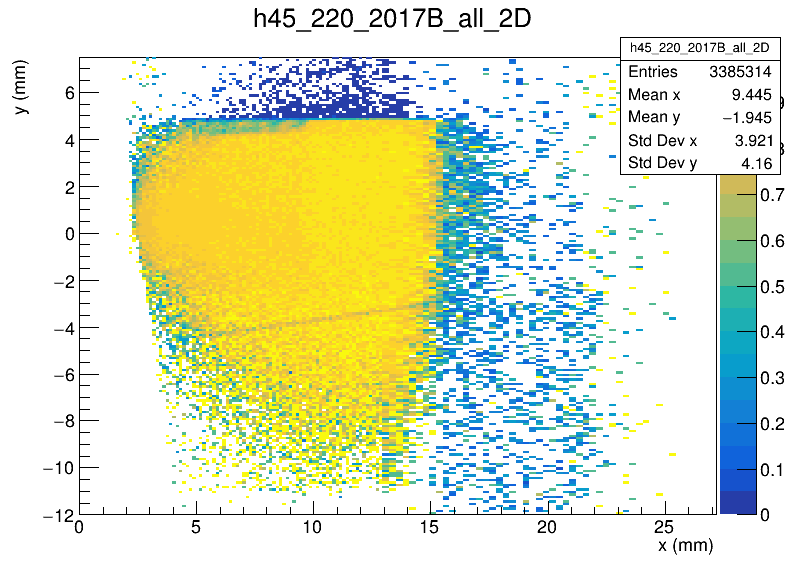

In [11]:
import uproot
import ROOT
from ROOT import TCanvas, TPad
# Step 2: Create a canvas and pads for drawing
canvas = TCanvas("canvas", "TH2D Histogram", 800, 600)
pad = TPad("pad", "pad", 0, 0, 1, 1)
pad.Draw()
pad.cd()

# Step 3: Draw the TH2D histogram
th2d_histogram.Draw("colz")

# Step 4: Update the canvas
canvas.Update()

# Step 5: Display the canvas in Jupyter Notebook
canvas.Draw()

In [44]:
def gethist(dettype_i,year_i,data_taking_period_i,arm_i):
    if arm_i==0:
        harm='h45'
    if arm_i==1:
        harm='h56'
    return f'Pixel/{year_i}/{data_taking_period_i}/{harm}_220_{data_taking_period_i}_all_2D'

from ROOT import TFile, TH1F, TCanvas, TString
def getSFs(year='2017',era='',fn="filename",IsSF="sf",name='',arm=0):
    data_taking_period=year+"B"
    print(fn)
    tf = TFile(fn)
    hname=gethist(name,year,era,arm)
    #hname="Pixel/"+year+"/"+data_taking_period+"/h"+"45"+"_220_"+data_taking_period+"_all_2D"
    fo = tf.Get(hname)
    
    print(f'Reading ---{hname}---- from ---{fn}--- ')
    
    Xbins=fo.GetNbinsX()
    Ybins=fo.GetNbinsY()
    X=[None]*(Xbins+1)
    
    Y=[None]*(Ybins+1)
    #print("Y: "+str(Y))
    values=[]
    errors=[]
    for i in range(1,Xbins+1):
        X[i-1]=fo.GetXaxis().GetBinLowEdge(i)
    X[Xbins]=fo.GetXaxis().GetBinUpEdge(Xbins)
    for i in range(1,Ybins+1):
        Y[i-1]=fo.GetYaxis().GetBinLowEdge(i)
    Y[Ybins]=fo.GetXaxis().GetBinUpEdge(Ybins)
    for i in range(1,Xbins + 1):
        for j in range(1,Ybins + 1):
            values.append(fo.GetBinContent(i,j))
            errors.append(fo.GetBinError(i,j))
    if IsSF=="eff":
        valSFs=schema.MultiBinning.parse_obj({
            "inputs":["x","y"],
            "nodetype": "multibinning",
            "edges": [
                X,
                Y,
            ],
            "content": values,
            "flow": 'error',
        })
        
        return valSFs
    else:
        return None
    
    

In [45]:
def yearwise(year="",files=[],names=[],valtypes=["eff"],eras=[],arms=[]):
    print(files)
    print(names)
    output = schema.Category.parse_obj({
                "nodetype": "category",
                "input": "Era",
                "content":[
                    schema.CategoryItem.parse_obj({
                        "key": era, 
                        "value":schema.Category.parse_obj({
                                    "nodetype": "category",
                                    "input": "ValType",
                                    "content":[
                                        schema.CategoryItem.parse_obj({
                                            "key": val, 
                                            "value": schema.Category.parse_obj({
                                                "nodetype": "category",
                                                "input": "arm",
                                                "content":[schema.CategoryItem.parse_obj({
                                                    "key": arm, 
                                                    "value":getSFs(year=year,era=era,fn=files[names[0]],IsSF=val,name=names[0],arm=arm)})
                                                           for arm in arms
                                                          ],
                                                        })
                                                    })
                                    for val in valtypes
                                ],
                        })
                    })
                    for era in [era_i for era_i in eras if year in era_i]
                ],
    })
                    
    return output

In [47]:
nameJSON='PROTON.json'
from correctionlib.schemav2 import CorrectionSet,Correction
import gzip
import correctionlib.schemav2 as schema

files=[
    {'multirp':"/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root"},
    {'radiation':"/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root"},
    {'singlerp':"/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root"}
]

corrs=[]
for whichfile,filelist in enumerate(files):
    namesSFs=list(filelist.keys())
    ## Get histnames
    h_keys=uproot.open(files[whichfile][namesSFs[0]]).keys()
    print(h_keys)
    hs=[h for h in h_keys if "all_2D" in h]
    hss=[h for h in hs if "copy" not in h]
    hss=[h.split(';')[0] for h in hss]
    hss=[h.split('/') for h in hss]
    ######
    dettypes=['Pixel']#list(set([dt[0] for dt in hss ]))
    years=list(set([dt[1] for dt in hss ]))
    data_taking_periods=list(set([dt[2] for dt in hss ]))

    print(f'{dettypes}')
    print(f'{years}')
    print(f'{data_taking_periods}')

    ###########################
    
    
    
    #print(f'Storing eff for {year}')
    #print(f'-----------------------')
    corr = Correction.parse_obj(
        {
            "version": 2,
            "name": "PROTON_"+str(namesSFs[0]),
            "description": f"PROTON JSON",
            "inputs": [
                {"name": "year","type": "string", "description": "year/scenario: example 2016, 2017 etc"},
                {"name": "Era","type": "string", "description": "Era"},
                {"name": "ValType","type": "string", "description": "eff"},
                #{"name": "WorkingPoint","type": "string", "description": "WP"},
                {"name": "arm","type": "int", "description": "0: arm 45, 1: arm 46"},
                {"type": "real", "name": "x", "description": "x(mm)"},
                {"type": "real", "name": "y", "description": "y(mm)"},
            ],
            "output": {"name": "weight", "type": "real", "description": "value of eff"},
            "data": schema.Category.parse_obj({
                "nodetype": "category",
                "input": "year",
                "content": [
                    schema.CategoryItem.parse_obj({"key":year,
                                                   "value": yearwise(year,files=filelist,names=namesSFs,eras=data_taking_periods,arms=[0,1])})
                    for year in years
                ]
            })
        })
    corrs.append(corr)

#Save JSON
cset = CorrectionSet(schema_version=2, corrections=corrs,description=f"PRO POG") 
with open(nameJSON, "w") as fout:
    fout.write(cset.json(exclude_unset=True, indent=4))

['Pixel;1', 'Pixel/2017;1', 'Pixel/2017/2017B;1', 'Pixel/2017/2017B/h45_220_2017B_all_2D;1', 'Pixel/2017/2017B/TE45_220_2017B_all_2D_copy;1', 'Pixel/2017/2017B/h56_220_2017B_all_2D;1', 'Pixel/2017/2017B/TE56_220_2017B_all_2D_copy;1', 'Pixel/2017/2017C1;1', 'Pixel/2017/2017C1/h45_220_2017C1_all_2D;1', 'Pixel/2017/2017C1/TE45_220_2017C1_all_2D_copy;1', 'Pixel/2017/2017C1/h56_220_2017C1_all_2D;1', 'Pixel/2017/2017C1/TE56_220_2017C1_all_2D_copy;1', 'Pixel/2017/2017C2;1', 'Pixel/2017/2017C2/h45_220_2017C2_all_2D;1', 'Pixel/2017/2017C2/TE45_220_2017C2_all_2D_copy;1', 'Pixel/2017/2017C2/h56_220_2017C2_all_2D;1', 'Pixel/2017/2017C2/TE56_220_2017C2_all_2D_copy;1', 'Pixel/2017/2017D;1', 'Pixel/2017/2017D/h45_220_2017D_all_2D;1', 'Pixel/2017/2017D/TE45_220_2017D_all_2D_copy;1', 'Pixel/2017/2017D/h56_220_2017D_all_2D;1', 'Pixel/2017/2017D/TE56_220_2017D_all_2D_copy;1', 'Pixel/2017/2017E;1', 'Pixel/2017/2017E/h45_220_2017E_all_2D;1', 'Pixel/2017/2017E/TE45_220_2017E_all_2D_copy;1', 'Pixel/2017/2017

/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root
Reading ---Pixel/2018/2018C/h56_220_2018C_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root
Reading ---Pixel/2018/2018B1/h45_220_2018B1_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root
Reading ---Pixel/2018/2018B1/h56_220_2018B1_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root
Reading ---Pixel/2018/2018D1/h45_220_2018D1_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_multiRP_reMiniAOD.root
Reading ---Pixel/2018/2018D1/h56

/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root
Reading ---Pixel/2017/2017B/h56_220_2017B_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root
Reading ---Pixel/2017/2017F/h45_220_2017F_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root
Reading ---Pixel/2017/2017F/h56_220_2017F_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root
Reading ---Pixel/2017/2017C/h45_220_2017C_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_radiation_reMiniAOD.root
Reading ---Pixel/201

/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root
Reading ---Pixel/2017/2017C2/h56_220_2017C2_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root
Reading ---Pixel/2017/2017F1/h45_220_2017F1_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root
Reading ---Pixel/2017/2017F1/h56_220_2017F1_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root
Reading ---Pixel/2017/2017F2/h45_220_2017F2_all_2D---- from ---/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root--- 
/eos/home-c/cmsdas/2023/short-ex-pps/pixelEfficiencies_singleRP_reMiniAOD.root
Reading ---Pixel/2017

In [1]:
from correctionlib import _core
#Download the correct JSON files 
evaluator = _core.CorrectionSet.from_file('PROTON.json')

```
evaluator["multirp or singlerp or radiation"].evaluate(-year-, -era-, -eff/unc-,-sector-,-x-,-y-)
```

In [2]:
valsf= evaluator["PROTON_multirp"].evaluate("2017","2017B","eff",0,10.0,-3.4)
print("eff is:"+str(valsf))

eff is:0.8902439024390244


In [3]:
valsf= evaluator["PROTON_singlerp"].evaluate("2017","2017B","eff",1,10.0,-3.4)
print("eff is:"+str(valsf))

eff is:0.8751087155317816


In [4]:
valsf= evaluator["PROTON_radiation"].evaluate("2017","2017B","eff",1,10.0,-3.4)
print("eff is:"+str(valsf))

eff is:0.9990861164265542


In [5]:
valsf= evaluator["PROTON_radiation"].evaluate("2018","2018B","eff",0,10.0,-3.4)
print("eff is:"+str(valsf))

eff is:0.9849031387848728


In [6]:
valsf_1= evaluator["PROTON_radiation"].evaluate("2018","2018B","eff",0,10.0,-3.4)
valsf_2= evaluator["PROTON_multirp"].evaluate("2018","2018B","eff",0,10.0,-3.4)

print("eff is:"+str(valsf_1 * valsf_2))

eff is:0.8643642262027796


In [ ]:
    
    #print("X: "+str(X))

In [9]:
evaluator.

{}

In [16]:
fo.GetXaxis().GetBinUpEdge(1)

NameError: name 'fo' is not defined

In [6]:
file = uproot.open(root_file)

In [8]:
file.keys()

['Pixel;1',
 'Pixel/2017;1',
 'Pixel/2017/2017B;1',
 'Pixel/2017/2017B/h45_220_2017B_all_2D;1',
 'Pixel/2017/2017B/TE45_220_2017B_all_2D_copy;1',
 'Pixel/2017/2017B/h56_220_2017B_all_2D;1',
 'Pixel/2017/2017B/TE56_220_2017B_all_2D_copy;1',
 'Pixel/2017/2017C1;1',
 'Pixel/2017/2017C1/h45_220_2017C1_all_2D;1',
 'Pixel/2017/2017C1/TE45_220_2017C1_all_2D_copy;1',
 'Pixel/2017/2017C1/h56_220_2017C1_all_2D;1',
 'Pixel/2017/2017C1/TE56_220_2017C1_all_2D_copy;1',
 'Pixel/2017/2017C2;1',
 'Pixel/2017/2017C2/h45_220_2017C2_all_2D;1',
 'Pixel/2017/2017C2/TE45_220_2017C2_all_2D_copy;1',
 'Pixel/2017/2017C2/h56_220_2017C2_all_2D;1',
 'Pixel/2017/2017C2/TE56_220_2017C2_all_2D_copy;1',
 'Pixel/2017/2017D;1',
 'Pixel/2017/2017D/h45_220_2017D_all_2D;1',
 'Pixel/2017/2017D/TE45_220_2017D_all_2D_copy;1',
 'Pixel/2017/2017D/h56_220_2017D_all_2D;1',
 'Pixel/2017/2017D/TE56_220_2017D_all_2D_copy;1',
 'Pixel/2017/2017E;1',
 'Pixel/2017/2017E/h45_220_2017E_all_2D;1',
 'Pixel/2017/2017E/TE45_220_2017E_all_2D_c

In [18]:
h_keys

['Pixel;1',
 'Pixel/2017;1',
 'Pixel/2017/2017B;1',
 'Pixel/2017/2017B/h45_220_2017B_all_2D;1',
 'Pixel/2017/2017B/TE45_220_2017B_all_2D_copy;1',
 'Pixel/2017/2017B/h56_220_2017B_all_2D;1',
 'Pixel/2017/2017B/TE56_220_2017B_all_2D_copy;1',
 'Pixel/2017/2017C1;1',
 'Pixel/2017/2017C1/h45_220_2017C1_all_2D;1',
 'Pixel/2017/2017C1/TE45_220_2017C1_all_2D_copy;1',
 'Pixel/2017/2017C1/h56_220_2017C1_all_2D;1',
 'Pixel/2017/2017C1/TE56_220_2017C1_all_2D_copy;1',
 'Pixel/2017/2017C2;1',
 'Pixel/2017/2017C2/h45_220_2017C2_all_2D;1',
 'Pixel/2017/2017C2/TE45_220_2017C2_all_2D_copy;1',
 'Pixel/2017/2017C2/h56_220_2017C2_all_2D;1',
 'Pixel/2017/2017C2/TE56_220_2017C2_all_2D_copy;1',
 'Pixel/2017/2017D;1',
 'Pixel/2017/2017D/h45_220_2017D_all_2D;1',
 'Pixel/2017/2017D/TE45_220_2017D_all_2D_copy;1',
 'Pixel/2017/2017D/h56_220_2017D_all_2D;1',
 'Pixel/2017/2017D/TE56_220_2017D_all_2D_copy;1',
 'Pixel/2017/2017E;1',
 'Pixel/2017/2017E/h45_220_2017E_all_2D;1',
 'Pixel/2017/2017E/TE45_220_2017E_all_2D_c

In [10]:
import rich

rich.print(evaluator)

<correctionlib._core.CorrectionSet object at 0x7ff7d9d64870>